In [1]:
import pandas as pd
import numpy as np
import math

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import csv
import glob
import os
from notify_run import Notify

In [330]:
#verry important
os.chdir(r"C:/Users/nieli/Documents/uva/thesis/code/")
print(os.getcwd())

notify = Notify()
results_folder = 'PPA/results/brouwer_vandenberg_2022/results-2021-09-16_12-55-16'

# change the plot colors and layout
sns.set_theme(style="whitegrid")

switched_colors = sns.color_palette("deep")
switched_colors[1] = switched_colors[3]
switched_colors[3] = sns.color_palette("deep")[1]
sns.set_palette(switched_colors)

C:\Users\nieli\Documents\uva\thesis\code


In [3]:
n_dimensional_benchmark = ['Ackley', 'Rosenbrock', 'Griewank', 'Rastrigrin', 'Schwefel', 'Ellipse', 'Cigar', 'Tablet', 'Sphere']
renames = {
    'mupluslambda':'PS',
    'mulambda':'CS',
    'tournament':'TS+R', 
    'roulette_wheel':'RWS',
    'linear_ranking':'LRS',
    'single_elitist_rws':'E-RWS',
    'single_elitist_tournament':'E-TS',
    'no_replacement_tournament':'TS-R'
}


## We load the necessary data

In [4]:
# Load all the best-so-far performances to select the median runs
best_so_far_files = glob.glob(results_folder + "/*_performance.csv")
li = []

for filename in best_so_far_files:
    
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)
frame['error'] = abs(frame['optimum'] - frame['best_during run'])
frame['selection_name'] = frame['selection_method'].apply(lambda x: renames[x])  

In [5]:
# we export the median_df of the plus selection (mupluslambda: default ppa selection) to another CSV file to compare it with the results of Vrielink and van den Berg 2021
frame[frame['selection_method'] == 'mupluslambda'][['benchmark_name','dimensions','best_during run','run_n']].to_csv('PPA/results/my_results_rep/my_results.csv', index=False)

this should be the total number of benchmark function instances per run: 59


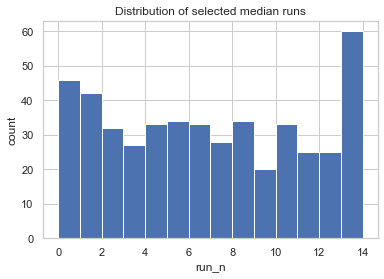

In [228]:
median_df = pd.DataFrame()

# group the data by selection method, benchmark_name, and dimensions and extract the run with the median performance
# if there exist multiple runs with the same performance, select the first
grouped = frame.groupby(['selection_method','benchmark_name','dimensions']).median().reset_index()

for i,row in grouped.iterrows():
    median_df = median_df.append(frame[
        (frame['selection_method'] == row['selection_method']) & 
        (frame['benchmark_name'] == row['benchmark_name']) & 
        (frame['dimensions'] == row['dimensions']) &
        (frame['error'] == row['error'])
    ].iloc[0])
    
#use this to check if all selection methods for all benchmark functions per dimension is present, should be 59:
print("this should be the total number of benchmark function instances per run: "+ str(len(median_df.groupby(['benchmark_name','dimensions']).count())))

# check the distribution of the selected run numbers
plt.hist(median_df.run_n, bins=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])

plt.xlabel('run_n')
plt.ylabel('count')
plt.title('Distribution of selected median runs')
plt.show()

In [7]:
# Load the detailed data of the median runs, containing the performance per generation
# p_df = performance data frame
# u_df = unique individuals data frame
# performance_details = glob.glob(results_folder + "/*_performance_over_generations.csv")
li = []

for i,row in median_df.iterrows():
    if row['benchmark_name'] in n_dimensional_benchmark:
        performance_filename = row['selection_method']+"-"+row['benchmark_name']+str(int(row['dimensions']))+"Drun-"+str(int(row['run_n']))+"_performance_over_generations.csv"
        unique_filename = row['selection_method']+"-"+row['benchmark_name']+str(int(row['dimensions']))+"Drun-"+str(int(row['run_n']))+"_unique_individuals.csv"
        
    if row['benchmark_name'] not in n_dimensional_benchmark:
        performance_filename = row['selection_method']+"-"+row['benchmark_name']+"run-"+str(int(row['run_n']))+"_performance_over_generations.csv"
        unique_filename = row['selection_method']+"-"+row['benchmark_name']+"run-"+str(int(row['run_n']))+"_unique_individuals.csv"
        
        
    p_df = pd.read_csv(results_folder+"/"+performance_filename, index_col=None, header=0)
    u_df = pd.read_csv(results_folder+"/"+unique_filename, index_col=None, header=0)
    
    
    p_df['selection_method'] = row['selection_method']
    p_df['selection_name'] = p_df['selection_method'].apply(lambda x: renames[x])  
    p_df['benchmark_name'] = row['benchmark_name']
    p_df['dimensions'] = int(row['dimensions'])
    p_df['error'] = abs(row['optimum'] - p_df['objective_value'])
    p_df['run_name'] = row['selection_method'] + "-" + row['benchmark_name'] + "-" + str(int(row['dimensions']))
    p_df = pd.merge(p_df, u_df, on=['generation'])
    
    li.append(p_df)   

performances = pd.concat(li, axis=0, ignore_index=True)

### We create heatmaps to compare magnitudes of differences

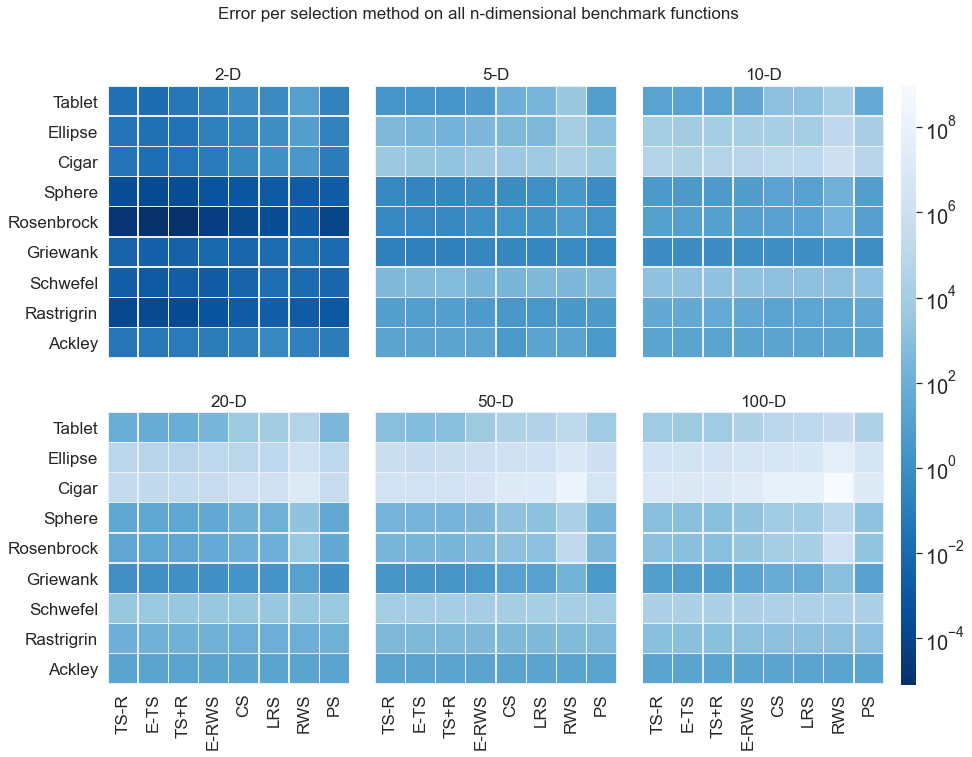

In [481]:
# only select the ndimensional benchmark functions and their dimensions
nd_final_performance = median_df[median_df['benchmark_name'].isin(n_dimensional_benchmark)]
dimensions = nd_final_performance.dimensions.unique()

# create a heatmap for each dimension for the ndimensional benchmark functions
fig, axs = plt.subplots(nrows=2,ncols=3, figsize=(20,11))

# color pallete for the heatmap and define order of display for selection methods and benchmark functions
heatmap_colors = sns.color_palette("Blues_r", as_cmap=True)
heatmap_column_order = ['no_replacement_tournament','single_elitist_tournament','tournament','single_elitist_rws','mulambda','linear_ranking','roulette_wheel','mupluslambda']
benchmark_row_order = ['Tablet','Ellipse','Cigar','Sphere','Rosenbrock','Griewank','Schwefel','Rastrigrin','Ackley']

# pre determine what the minimum and maximum heatmap values are so the colour scale is equal for the heatmaps per dimension:
min_error = nd_final_performance.error.min()
max_error = nd_final_performance.error.max()

# start the counter at -1 so the first plot is placed at position 0
column = 0
row = 0

# plot for each dimension a seperate heatmap, only the first heatmap has y labels, and only the last has the colorbar
for dim in dimensions:
    
    if column==3:
        row+=1
        column=0
    data = nd_final_performance[nd_final_performance.dimensions == dim][['selection_name','benchmark_name','error']]
    plot_data = data.pivot(index='benchmark_name', columns='selection_name', values='error')
    plot_data = plot_data[[renames[x] for x in heatmap_column_order]]
    plot_data = plot_data.loc[benchmark_row_order]
    
    if (dim == 2) or (dim==20):
        ax = sns.heatmap(plot_data, ax=axs[row][column], norm=LogNorm(vmin=min_error, vmax=max_error), cmap=heatmap_colors, cbar=False, square=True, linewidths=.4, linecolor='#eaeffb')
    elif dim == 100:
        cbar_ax = fig.add_axes([.794, .124, .01, 0.757]) #[Horizontal coordinate of the lower left corner,  Vertical coordinate of the lower left corner, Width of the subplot,  Height of the subplot]
        
        ax = sns.heatmap(plot_data, ax=axs[row][column], norm=LogNorm(vmin=min_error, vmax=max_error), cmap=heatmap_colors, square=True, cbar_ax=cbar_ax, linewidths=.4, linecolor='#eaeffb')#norm=LogNorm(vmin=min_error, vmax=max_error); midpoint=1
        ax.set(yticklabels=[])
        ax.collections[0].colorbar.ax.yaxis.set_ticks([], minor=True)
        ax.collections[0].colorbar.ax.tick_params(labelsize=20)
        
    else:
        ax = sns.heatmap(plot_data, ax=axs[row][column], norm=LogNorm(vmin=min_error, vmax=max_error), cmap=heatmap_colors, cbar=False, square=True,  linewidths=.4, linecolor='#eaeffb') #norm=LogNorm(vmin=min_error, vmax=max_error)
        ax.set(yticklabels=[])
    
    if row <1:
        ax.set(xticklabels=[])
    
    ax.set_title(f'{int(dim)}-D', fontsize=17)
    ax.set_ylabel('') 
    ax.set_xlabel('')
    ax.tick_params(labelsize=17)
    
    column+=1

fig.subplots_adjust(wspace=-0.540) 
# fig.tight_layout(rect=[0, 0, .9, 1])
fig.suptitle("Error per selection method on all n-dimensional benchmark functions", fontsize=17)
plt.savefig(f'PPA/notebooks/brouwer_vandenberg_2022/nd_heatmap.png', bbox_inches='tight', format='png', dpi=1200)
# plt.savefig(f'PPA/notebooks/brouwer_vandenberg_2022/nd_heatmap.eps', bbox_inches='tight', format='eps', dpi=1200)

plt.show()

In [ ]:
# # Here we check the growth over the dimensions, checking if we can find a pattern 

# fig, axs = plt.subplots(nrows=9,ncols=8, figsize=(50,50))
# row = 0
# for benchmark in n_dimensional_benchmark:
    
#     per_benchmark = median_df[median_df['benchmark_name'] == benchmark]
#     counter = 0
    
#     for selection_method in per_benchmark.selection_method.unique():
        
#         data = per_benchmark[per_benchmark['selection_method'] == selection_method]
#         ax = sns.lineplot(y=data['error'],x=data['dimensions'], label=renames[selection_method], linestyle='--', ax=axs[row][counter], marker='o',markerfacecolor='red')
#         ax.set_title(benchmark)
# #         ax.set_title
    
#         counter+=1
#     row+=1
    
# plt.show()

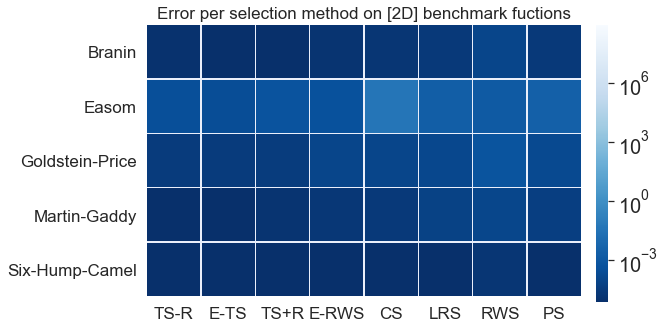

In [457]:
# NOTE: first the previous heatmaps need to be created in order to create this one

# define a custom benchmark order, and use the previous defined column order of the nd data
custom_2d_benchmark_order = ['Branin','Easom','Goldstein-Price','Martin-Gaddy','Six-Hump-Camel']

# plot the heatmap for the benchmark functions solely present in 2 dimensions
two_d_data = median_df[~median_df['benchmark_name'].isin(n_dimensional_benchmark)].pivot(index='benchmark_name', columns='selection_name', values='error')
two_d_data = two_d_data[[renames[x] for x in heatmap_column_order]]
two_d_data = two_d_data.loc[custom_2d_benchmark_order]

fig, axs = plt.subplots(ncols=1, figsize=(10,5))
cbar_ax = fig.add_axes([0.835, .11, .017, 0.77]) #[Horizontal coordinate of the lower left corner,  Vertical coordinate of the lower left corner, Width of the subplot,  Height of the subplot]
ax = sns.heatmap(two_d_data, ax=axs, norm=LogNorm(vmin=min_error, vmax=max_error), cmap=heatmap_colors, square=True, cbar_ax=cbar_ax, linewidths=.4, linecolor='#eaeffb')
ax.collections[0].colorbar.ax.tick_params(labelsize=14)
ax.set_ylabel('')
ax.set_xlabel('')
ax.tick_params(labelsize=17)
ax.collections[0].colorbar.ax.tick_params(labelsize=20)
ax.set_title('Error per selection method on [2D] benchmark fuctions',fontsize=17)
# plt.savefig(f'PPA/notebooks/brouwer_vandenberg_2022/2d_heatmap.eps', bbox_inches='tight', format='eps', dpi=1200)
plt.savefig(f'PPA/notebooks/brouwer_vandenberg_2022/2d_heatmap.png', bbox_inches='tight', format='png', dpi=1200)
plt.show()

### We look at how the selection methods compare to eachother

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

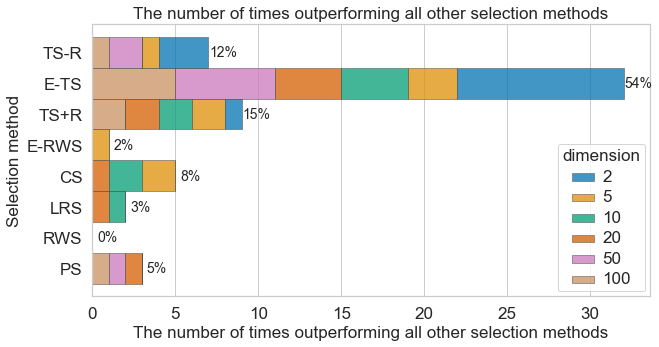

In [230]:
# loop through all data and see how many per selection method per benchmark function for every dimension a selection method has the lowest error
plt.figure(figsize=(10, 5))
data = median_df
count_df = pd.DataFrame(columns=['selection_method','dimension','counter'])

# Defining a custom order for the bars
custom_order = ['no_replacement_tournament','single_elitist_tournament','tournament','single_elitist_rws','mulambda','linear_ranking','roulette_wheel','mupluslambda']

# we add an entry to count_df for every time a selection method "won" on a benchmark function instance
for benchmark in data.benchmark_name.unique():
    for dimension in data[data.benchmark_name == benchmark].dimensions.unique():
        benchmark_dim_data = data[(data.benchmark_name == benchmark) & (data.dimensions == dimension)]
        min_id = benchmark_dim_data.error.argmin()
        count_df = count_df.append({"selection_method":benchmark_dim_data.iloc[min_id].selection_method,"dimension":int(dimension),"counter":1}, ignore_index=True)

# little "hack" to include the selection methods that never won, not the counter=0
for selection_method in data.selection_method.unique():
    count_df = count_df.append({"selection_method":selection_method,"dimension":int(2),"counter":0}, ignore_index=True)
        
# now we sum the number of times a selection method won per dimension
count_df = count_df.groupby(['selection_method','dimension']).sum().sort_values(by=['counter','dimension'],ascending=False)
count_df = count_df.reset_index()

# sum by selection method for the text at the end of a bar applied later, and the order of the bars from high to low
summed_by_selection_method = count_df.groupby('selection_method').sum().sort_values(by=['counter'],ascending=False).reset_index()

# (old) make a column that handles the order based on the grouped (by selection method only) sum
# i = 0
# for name in summed_by_selection_method.selection_method:
#     count_df.loc[count_df.selection_method == name,'order'] = i
#     i+=1
# count_df = count_df.sort_values(by='order')


# (new) sort the dataframe according to a custom order
i = 0
for name in custom_order:
    count_df.loc[count_df.selection_method == name,'order'] = i
    i+=1
count_df = count_df.sort_values('order')

# plot the data
count_df['selection_method'] = [renames[x] for x in count_df['selection_method']]
g = sns.histplot(count_df,y='selection_method', weights='counter',multiple="stack",hue='dimension',palette="colorblind", edgecolor=".3", linewidth=0.5)

# we add percentages at the end of each stacked bar
i = 0
for index,row in count_df.groupby('selection_method').sum().loc[[renames[x] for x in custom_order]].iterrows():
    g.text(row.counter+0.9, abs(0-i), f'{round((row.counter/59)*100)}%', horizontalalignment='center', verticalalignment='center', fontsize=14)
    i+=1

# some plot formatting:
fontsize = 17
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.setp(g.get_legend().get_texts(), fontsize='17') # for legend text
plt.setp(g.get_legend().get_title(), fontsize='17') # for legend title

# plt.grid()
g.grid(axis='y')
plt.title('The number of times outperforming all other selection methods', fontsize=fontsize)
plt.ylabel('Selection method', fontsize=fontsize)
plt.xlabel('The number of times outperforming all other selection methods', fontsize=fontsize)
plt.savefig(f'PPA/notebooks/brouwer_vandenberg_2022/outperforming_all.eps', bbox_inches='tight', format='eps', dpi=1200)

plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

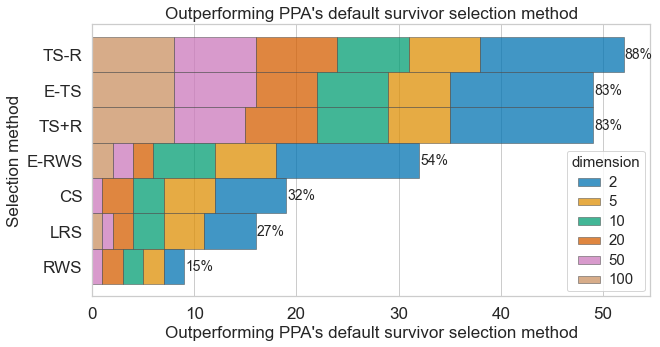

In [327]:
# we now compare how well each selection method performs in comparison to the default selection method of the PPA, Plus Selection (PS) or mupluslambda
plt.figure(figsize=(10, 5))
data = median_df
outperforms_df = pd.DataFrame(columns=['selection_method','dimension','counter'])

# we loop thourgh the benchmark function instances and compare the error of ps with the error of every selection method for the same benchmark function instance
for benchmark in data.benchmark_name.unique():
    
    for dim in data[data.benchmark_name == benchmark].dimensions.unique():
        ps_error = data[(data['selection_method']=='mupluslambda') & (data['benchmark_name']==benchmark) & (data['dimensions']==dim)]['error']
        
        for method in data.selection_method.unique():

            selection_method_error = data[(data['selection_method']==method) & (data['benchmark_name']==benchmark) & (data['dimensions']==dim)]['error']
            if float(ps_error) > float(selection_method_error):
                outperforms_df= outperforms_df.append({"selection_method":method,"dimension":int(dim),"counter":1}, ignore_index=True)
                

# we group the data per selection method, per dimension (to create the seperate bins)                
outperforms_df = outperforms_df.groupby(['selection_method','dimension']).sum().sort_values(by=['counter'],ascending=False)

#we sort the data by the selection method with the highest number of times outperforming the ps selection method
outperforms_df = outperforms_df.loc[(outperforms_df.groupby('selection_method').sum().sort_values('counter', ascending=False).index.values)].reset_index()

# plot the data in a stacked bar chart
outperforms_df['selection_method'] = [renames[x] for x in outperforms_df['selection_method']]
g = sns.histplot(outperforms_df,y='selection_method', weights='counter',multiple="stack",hue='dimension',palette="colorblind", edgecolor=".3", linewidth=0.5)

# add labels at the end of the barchart
i = 0
for index,row in outperforms_df.groupby('selection_method').sum().sort_values(by=['counter'],ascending=False).iterrows():
    g.text(row.counter+1.5, abs(0-i), f'{round((row.counter/59)*100)}%', horizontalalignment='center', verticalalignment='center', fontsize=14)
#     g.text(row.counter+1.5, abs(0-i), r'$\dfrac{%d}{59}$'%(row.counter), horizontalalignment='center', verticalalignment='center', fontsize=15)
    i+=1
    
# formatting of the plot    
fontsize = 17
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)    
plt.setp(g.get_legend().get_texts(), fontsize='15') # for legend text
plt.setp(g.get_legend().get_title(), fontsize='15') # for legend title


g.grid(axis='x')
plt.title("Outperforming PPA's default survivor selection method", fontsize=fontsize)
plt.ylabel('Selection method', fontsize=fontsize)
plt.xlabel("Outperforming PPA's default survivor selection method",fontsize=fontsize)
plt.grid()
plt.savefig(f'PPA/notebooks/brouwer_vandenberg_2022/outperforming_ps.eps', bbox_inches='tight', format='eps', dpi=1200)


plt.show()

### Here we load all the fitness data, which takes increadibly long since i saved it as a csv containing dicts instead of lists.....

In [15]:
# # # create a data frame to store all fitness and rank information per individual over the generations
# # fitness_df = pd.DataFrame(columns=['id','selection_method','rank','fitness','generation'])
# fitness_df = pd.DataFrame()
# for selection_method in selection_methods:
#     for benchmark_name in median_df.benchmark_name.unique():
#         for dimensions in median_df[median_df['benchmark_name'] == benchmark_name].dimensions.unique():
#             run_n = median_df[
#                 (median_df['selection_method'] == selection_method) &
#                 (median_df['benchmark_name'] == benchmark_name) &
#                 (median_df['dimensions'] == dimensions)
#             ].run_n

#             #load the fitness data for the benchmark instance and selection method
#             if benchmark_name in n_dimensional_benchmark:
#                 fitness_filename = selection_method+"-"+benchmark_name+str(int(dimensions))+"Drun-"+str(int(run_n))+"_fitness_ranks.csv"
#             else:
#                 fitness_filename = selection_method+"-"+benchmark_name+"run-"+str(int(run_n))+"_fitness_ranks.csv"


#             with open(results_folder+"/"+fitness_filename) as file:
#                 reader = csv.DictReader(file)
#                 for row in reader:
#                     to_list = list(row.items())

#                     list_data = [eval(str.replace(item,'"','')) for item in to_list[1][1]]
#                     list_data.append(eval(str.replace(to_list[0][1],'"','')))

#                     temp_df = pd.DataFrame(list_data)
#                     temp_df['selection_method'] = selection_method
#                     temp_df['benchmark'] = benchmark_name
#                     temp_df['dimensions'] = dimensions
#                     fitness_df = fitness_df.append(temp_df, ignore_index=True)


#### Export it so we don't have to loop through and eval again

In [16]:
# fitness_df.to_csv(results_folder+"/ets_erws_ps-fitness_ranks/ets_erws_ps-fitness_ranks-all.csv")

In [190]:
fitness_df = pd.read_csv(results_folder+"/ets_erws_ps-fitness_ranks/ets_erws_ps-fitness_ranks-all.csv", index_col=0)
fitness_df = fitness_df.reset_index(drop=True)

C:\Users\nieli\miniconda3\envs\ppa_data_vis\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


### We now create the plots containing error, median fitness, and number of distinct individuals per generation

In [191]:
fitness_df

id  rank   fitness  generation    selection_method benchmark  \
0            1     2  0.453332           0  single_elitist_rws    Ackley   
1           22     3  0.250263           0  single_elitist_rws    Ackley   
2            8     4  0.188341           0  single_elitist_rws    Ackley   
3            9     5  0.160999           0  single_elitist_rws    Ackley   
4           10     6  0.148826           0  single_elitist_rws    Ackley   
...        ...   ...       ...         ...                 ...       ...   
4187245  46462    27  0.025019        1067        mupluslambda    Tablet   
4187246  47581    28  0.020841        1067        mupluslambda    Tablet   
4187247  47957    29  0.018705        1067        mupluslambda    Tablet   
4187248  46682    30  0.017986        1067        mupluslambda    Tablet   
4187249  49556     1  0.982014        1067        mupluslambda    Tablet   

         dimensions  
0               2.0  
1               2.0  
2               2.0  
3               2.0  
4               2.0  
...             ...  
4187245       100.0  
4187246       100.0  
4187247       100.0  
4187248       100.0  
4187249       100.0  

[4187250 rows x 7 columns]

#### We create a new gid of figures and plot the figures in them

In [195]:
fitness_plot_data_rosenbrock


generation       id  rank   fitness  dimensions
0              0     15.5  15.5  0.320460       100.0
1              1     15.5  15.5  0.320460       100.0
2              2     22.5  15.5  0.222379       100.0
3              3     24.5  15.5  0.188978       100.0
4              4     79.5  15.5  0.704079       100.0
...          ...      ...   ...       ...         ...
1132        1132  43780.0  15.5  0.255915       100.0
1133        1133  43780.0  15.5  0.255915       100.0
1134        1134  43780.0  15.5  0.255915       100.0
1135        1135  43780.0  15.5  0.255915       100.0
1136        1136  43780.0  15.5  0.242015       100.0

[1137 rows x 5 columns]

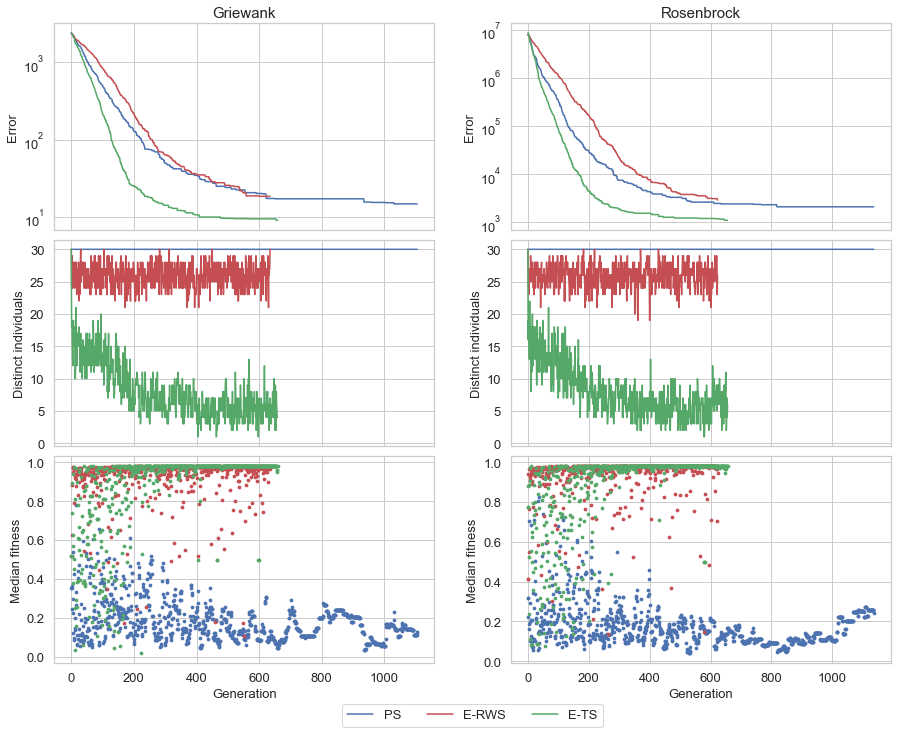

In [332]:
selection_methods = ['mupluslambda','single_elitist_rws','single_elitist_tournament']

fig, axs = plt.subplots(nrows=3,ncols=2,figsize=(15,12))

## We start with the error of the Griewank:
griewank_performance = performances[(performances['benchmark_name'] == 'Griewank') & (performances['dimensions'] == 100)]
rosenbrock_performance = performances[(performances['benchmark_name'] == 'Rosenbrock') & (performances['dimensions'] == 100)]

griewank_fitness = fitness_df[(fitness_df['benchmark'] == 'Griewank') & (fitness_df['dimensions'] == 100)]
rosenbrock_fitness = fitness_df[(fitness_df['benchmark'] == 'Rosenbrock') & (fitness_df['dimensions'] == 100)]

for selection_method in selection_methods:
    # Performance over the generations    
    sns.lineplot(x=griewank_performance[griewank_performance['selection_method'] == selection_method].generation, y=griewank_performance[griewank_performance['selection_method'] == selection_method].error, label=renames[selection_method], ax=axs[0][0])
    sns.lineplot(x=rosenbrock_performance[rosenbrock_performance['selection_method'] == selection_method].generation, y=rosenbrock_performance[rosenbrock_performance['selection_method'] == selection_method].error, label=renames[selection_method], ax=axs[0][1])
    
    # Distinct individuals over the generations     
    sns.lineplot(x=griewank_performance[griewank_performance['selection_method'] == selection_method].generation, y=griewank_performance[griewank_performance['selection_method'] == selection_method].unique_ids, label=renames[selection_method], ax=axs[1][0])
    sns.lineplot(x=rosenbrock_performance[rosenbrock_performance['selection_method'] == selection_method].generation, y=rosenbrock_performance[rosenbrock_performance['selection_method'] == selection_method].unique_ids, label=renames[selection_method], ax=axs[1][1])
    
    # Median fitness over the generations
    fitness_plot_data_griewank = griewank_fitness[griewank_fitness['selection_method'] == selection_method].groupby('generation').median().reset_index()
    sns.scatterplot(x=fitness_plot_data_griewank.generation, y=fitness_plot_data_griewank.fitness, label=renames[selection_method], ax=axs[2][0], marker='o', s=14, linewidth=0)
    
    fitness_plot_data_rosenbrock = rosenbrock_fitness[rosenbrock_fitness['selection_method'] == selection_method].groupby('generation').median().reset_index()
    sns.scatterplot(x=fitness_plot_data_rosenbrock.generation, y=fitness_plot_data_rosenbrock.fitness, label=renames[selection_method], ax=axs[2][1], marker="o", s=14, linewidth=0)

# set the performance graphs's vertical axis to loc scale
axs[0][0].set(yscale="log")
axs[0][1].set(yscale="log")

# remove the generations ticks from the x axis of the first row for space savings
axs[0][0].set(xticklabels=[], xlabel=None)
axs[0][1].set(xticklabels=[], xlabel=None)
axs[1][0].set(xticklabels=[], xlabel=None)
axs[1][1].set(xticklabels=[], xlabel=None)

# increase tick size
tick_font_size = 13
axs[0][0].tick_params(axis='y', labelsize=tick_font_size)
axs[0][1].tick_params(axis='y', labelsize=tick_font_size)
axs[1][0].tick_params(axis='y', labelsize=tick_font_size)
axs[1][1].tick_params(axis='y', labelsize=tick_font_size)
axs[2][0].tick_params(axis='y', labelsize=tick_font_size)
axs[2][1].tick_params(axis='y', labelsize=tick_font_size)

axs[2][0].tick_params(axis='x', labelsize=tick_font_size)
axs[2][1].tick_params(axis='x', labelsize=tick_font_size)

# set the label text and size
axs[0][0].set_ylabel('Error', fontsize=tick_font_size)
axs[0][1].set_ylabel('Error', fontsize=tick_font_size)

axs[1][0].set_ylabel('Distinct individuals', fontsize=tick_font_size)
axs[1][1].set_ylabel('Distinct individuals', fontsize=tick_font_size)

axs[2][0].set_ylabel('Median fitness', fontsize=tick_font_size)
axs[2][1].set_ylabel('Median fitness', fontsize=tick_font_size)

axs[2][0].set_xlabel('Generation', fontsize=tick_font_size)
axs[2][1].set_xlabel('Generation', fontsize=tick_font_size)

# remove the legends from the plots, we add a new one to the second last one
axs[0][0].get_legend().remove()
axs[0][1].get_legend().remove()
axs[1][0].get_legend().remove()
axs[1][1].get_legend().remove()
axs[2][0].get_legend().remove()
axs[2][1].get_legend().remove()

# set title for the first two plots
axs[0][0].set_title('Griewank', fontsize=15)
axs[0][1].set_title('Rosenbrock', fontsize=15)

# plt.tick_params(axis='x', labelsize=22)
# plt.tick_params(axis='y', labelsize=22)

# plt.subplots_adjust(hspace = 0.05)

fig.subplots_adjust(bottom=0.14, hspace=0.05)  # create some space below the plots by increasing the bottom-value
axs.flatten()[-3].legend(loc='upper center', bbox_to_anchor=(-0.10, -1.22), ncol=3, fontsize=tick_font_size)

plt.savefig(f'PPA/notebooks/brouwer_vandenberg_2022/behaviourGriewankRosenbrock.png', bbox_inches='tight', format='png', dpi=1200)

plt.show()


### Starting with the error over the generations

No handles with labels found to put in legend.


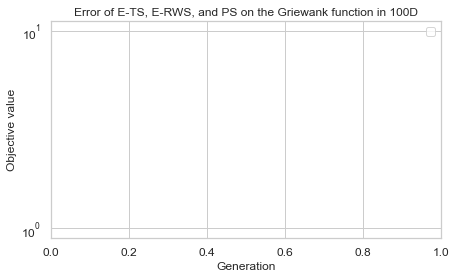

In [119]:
# we plot the error per generation for selected "selection methods"
def error_griewank_plot():
    benchmark_name = "Griewank"
    dimensions = 100
    # we place the selection methods under comparison in a list for later use
    selection_methods = ['mupluslambda','single_elitist_rws','single_elitist_tournament']

    ets_data = performance_df[performance_df['selection_method'] == 'single_elitist_tournament'] #elitist tournament selection data
    erws_data = performance_df[performance_df['selection_method'] == 'single_elitist_rws'] #elitist rws data
    ps_data = performance_df[performance_df['selection_method'] == 'mupluslambda'] #plus selection data

    sns.lineplot(x=ps_data.generation, y=ps_data.error, label=renames['mupluslambda'], ax=axs[0][0])
    sns.lineplot(x=erws_data.generation, y=erws_data.error, label=renames['single_elitist_rws'], ax=axs[0][0])
    sns.lineplot(x=ets_data.generation, y=ets_data.error, label=renames['single_elitist_tournament'], ax=axs[0][0])

    # plot formatting
#     plt.title(f'Error of {renames["single_elitist_tournament"]}, {renames["single_elitist_rws"]}, and {renames["mupluslambda"]} on the {benchmark_name} function in {dimensions}D', fontsize=12)
#     plt.ylabel('Objective value', fontsize=12)
#     plt.xlabel('Generation', fontsize=12)
#     plt.yscale("log")
#     plt.tick_params(axis='x', labelsize=12)
#     plt.tick_params(axis='y', labelsize=12)
#     plt.legend(fontsize=12)
    return plt
# plt.savefig(f'PPA/notebooks/brouwer_vandenberg_2022/error_value_ETS_PS_ERWS_Rosenbrock.eps', bbox_inches='tight', format='eps', dpi=1200)
# plt.savefig(f'PPA/notebooks/brouwer_vandenberg_2022/error_value_ETS_PS_ERWS_Rosenbrock.eps', bbox_inches='tight', format='eps', dpi=1200)

# plt.show()

In [121]:
plt.show()

## First we plot for the Rosenbrock next for the Schwefel, both in 100D

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


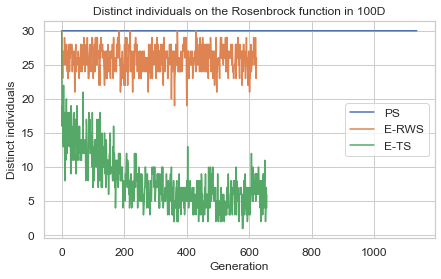

In [90]:
# plot the nubmer of distinct individuals using the variables set in the previous cell
fig,ax = plt.subplots(figsize=(7,4))
benchmark_name = "Rosenbrock"
dimensions = 100
sns.lineplot(x=ps_data.generation, y=ps_data.unique_ids, label=renames['mupluslambda'])
sns.lineplot(x=erws_data.generation, y=erws_data.unique_ids, label=renames['single_elitist_rws'])
sns.lineplot(x=ets_data.generation, y=ets_data.unique_ids, label=renames['single_elitist_tournament'])


# plot formatting
plt.title(f'Distinct individuals on the {benchmark_name} function in {dimensions}D', fontsize=12)
plt.ylabel('Distinct individuals', fontsize=12)
plt.xlabel('Generation', fontsize=12)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.legend(fontsize=12, loc="center right")
plt.savefig(f'PPA/notebooks/brouwer_vandenberg_2022/distinct_ETS_PS_ERWS_Rosenbrock.eps', bbox_inches='tight', format='eps', dpi=1200)

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


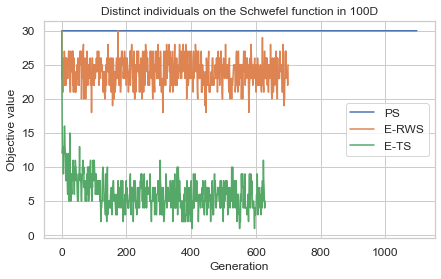

In [82]:
# plot the nubmer of distinct individuals using the variables set in the previous cell
fig,ax = plt.subplots(figsize=(7,4))
benchmark_name = "Schwefel"
dimensions = 100
plot_data = performances[(performances['benchmark_name'] == benchmark_name) & (performances['dimensions'] == dimensions)]

for selection_method in selection_methods:
    sns.lineplot(x=plot_data[plot_data['selection_method'] == selection_method].generation, y=plot_data[plot_data['selection_method'] == selection_method].unique_ids, label=renames[selection_method])

# sns.lineplot(x=erws_data.generation, y=erws_data.unique_ids, label=renames['single_elitist_rws'])
# sns.lineplot(x=ets_data.generation, y=ets_data.unique_ids, label=renames['single_elitist_tournament'])


# plot formatting
plt.title(f'Distinct individuals on the {benchmark_name} function in {dimensions}D', fontsize=12)
plt.ylabel('Distinct individuals', fontsize=12)
plt.xlabel('Generation', fontsize=12)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.legend(fontsize=12, loc="center right")
plt.savefig(f'PPA/notebooks/brouwer_vandenberg_2022/distinct_ETS_PS_ERWS_Schwefel.eps', bbox_inches='tight', format='eps', dpi=1200)

plt.show()

### Lets plot the median fitness!

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

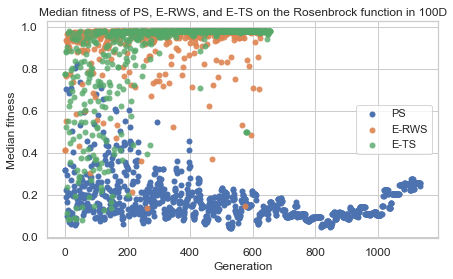

In [58]:
fix, ax = plt.subplots(figsize=(7, 4))
benchmark_name = "Rosenbrock"
dimensions = 100
# show the median fitness per generation for the selection methods
i = 0
for selection_method in selection_methods:
    
    plot_data = fitness_df[(fitness_df['selection_method'] == selection_method)&(fitness_df['benchmark'] == benchmark_name) & (fitness_df['dimensions'] == dimensions)].groupby('generation').median()
    sns.scatterplot(x='generation', y='fitness',data=plot_data, label=renames[selection_method], alpha=1-(i/10), linewidth=0)
    i+=1

# plot formatting
plt.title(f'Median fitness of {renames[selection_methods[0]]}, {renames[selection_methods[1]]}, and {renames[selection_methods[2]]} on the {benchmark_name} function in {dimensions}D')
ax.legend(loc="center right")
# plt.legend(loc="upper right", bbox_to_anchor=(0.9,0.99)) #position of legend for the slides
plt.ylabel('Median fitness', fontsize=12)
plt.xlabel('Generation', fontsize=12)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
plt.savefig(f'PPA/notebooks/brouwer_vandenberg_2022/fitness_ETS_PS_ERWS_Rosenbrock.eps', bbox_inches='tight', format='eps', dpi=1200)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

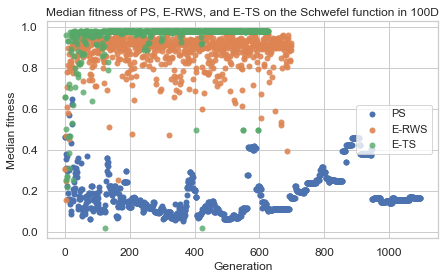

In [79]:
fix, ax = plt.subplots(figsize=(7, 4))
benchmark_name = "Schwefel"
dimensions = 100
# show the median fitness per generation for the selection methods
i = 0
for selection_method in selection_methods:
    
    plot_data = fitness_df[(fitness_df['selection_method'] == selection_method)&(fitness_df['benchmark'] == benchmark_name) & (fitness_df['dimensions'] == dimensions)].groupby('generation').median()
    sns.scatterplot(x='generation', y='fitness',data=plot_data, label=renames[selection_method], alpha=1-(i/10), linewidth=0)
    i+=1

# plot formatting
plt.title(f'Median fitness of {renames[selection_methods[0]]}, {renames[selection_methods[1]]}, and {renames[selection_methods[2]]} on the {benchmark_name} function in {dimensions}D')
ax.legend(loc="center right")
# plt.legend(loc="upper right", bbox_to_anchor=(0.9,0.99)) #position of legend for the slides
plt.ylabel('Median fitness', fontsize=12)
plt.xlabel('Generation', fontsize=12)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
plt.savefig(f'PPA/notebooks/brouwer_vandenberg_2022/fitness_ETS_PS_ERWS_Schwefel.eps', bbox_inches='tight', format='eps', dpi=1200)
plt.show()

### Manually check if the shapes of all the benchmark function plots are similar

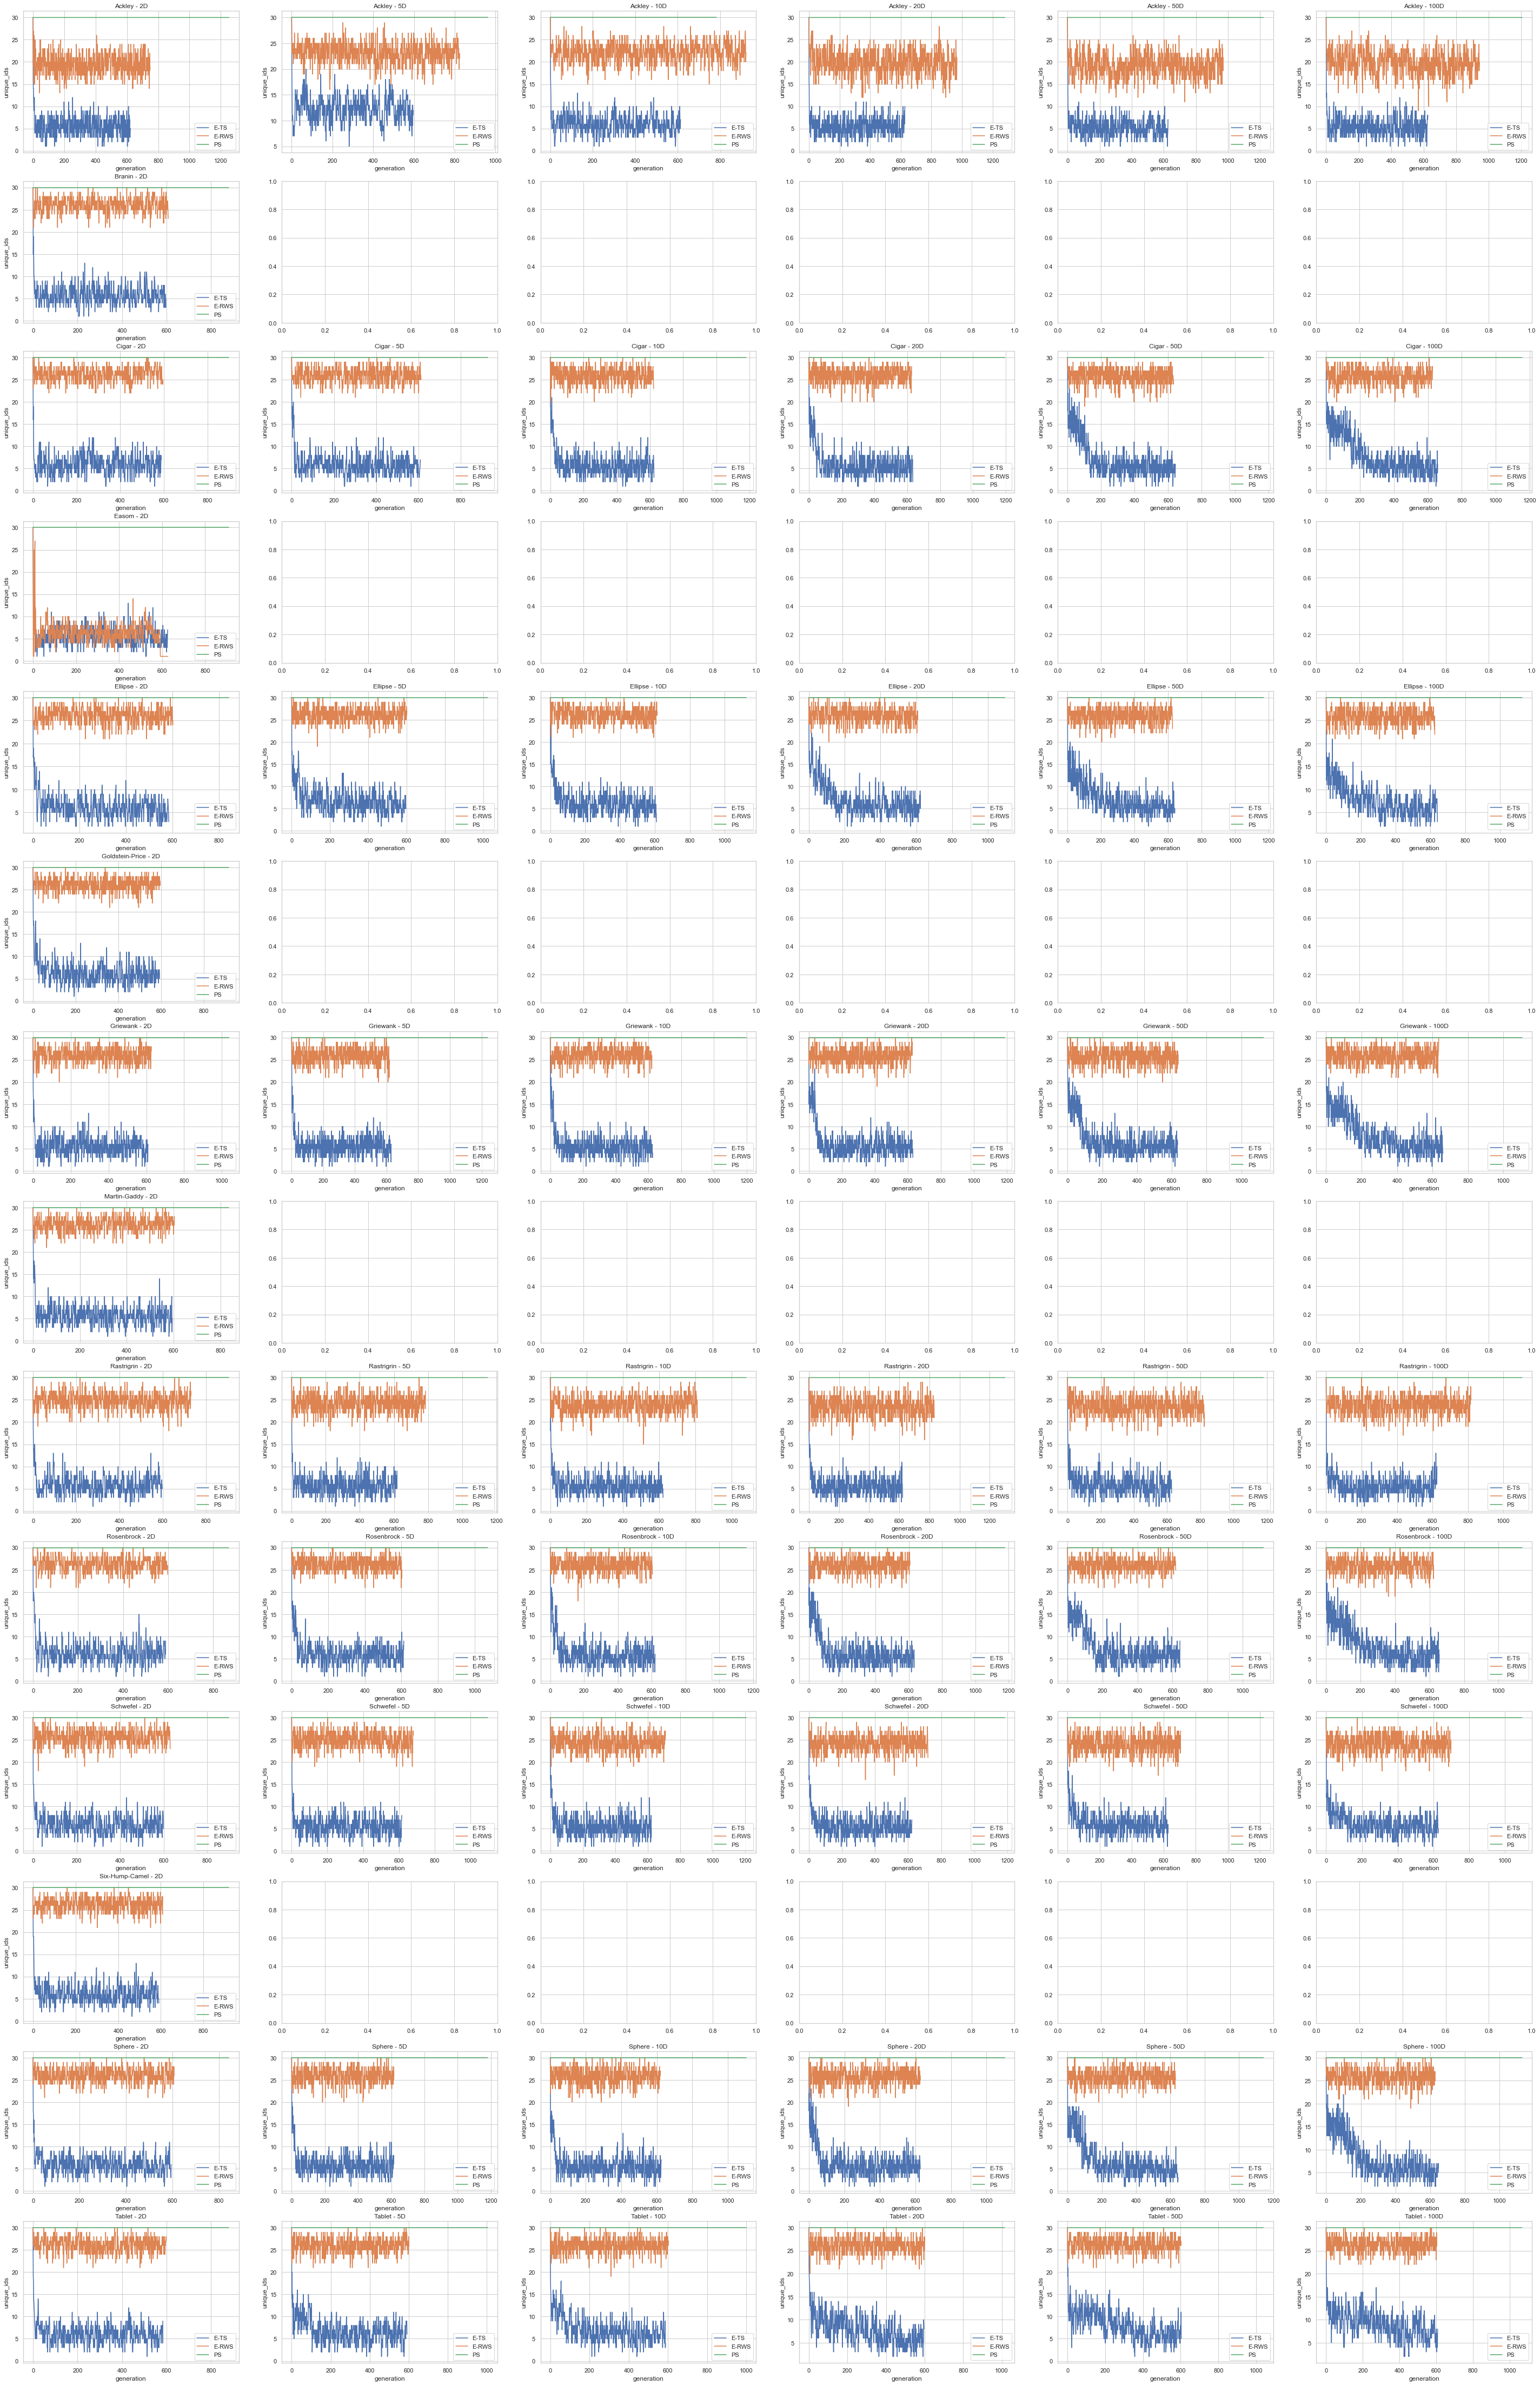

In [72]:
fig, axs = plt.subplots(nrows=14,ncols=6, figsize=(50,80))
row = 0
for benchmark in performances.benchmark_name.unique():
    column = 0
    selection_benchmark_data = performances[performances['benchmark_name'] == benchmark]
    for dim in selection_benchmark_data.dimensions.unique():
        data = selection_benchmark_data[selection_benchmark_data['dimensions'] == dim]
        sns.lineplot(x=data[data['selection_method'] == 'single_elitist_tournament'].generation, y=data[data['selection_method'] == 'single_elitist_tournament'].unique_ids, label=renames['single_elitist_tournament'],ax=axs[row][column]).set_title(f'{benchmark} - {dim}D')
        sns.lineplot(x=data[data['selection_method'] == 'single_elitist_rws'].generation, y=data[data['selection_method'] == 'single_elitist_rws'].unique_ids, label=renames['single_elitist_rws'],ax=axs[row][column]).set_title(f'{benchmark} - {dim}D')
        sns.lineplot(x=data[data['selection_method'] == 'mupluslambda'].generation, y=data[data['selection_method'] == 'mupluslambda'].unique_ids, label=renames['mupluslambda'], ax=axs[row][column]).set_title(f'{benchmark} - {dim}D')
        
        column+=1
    row+=1
    
plt.show()

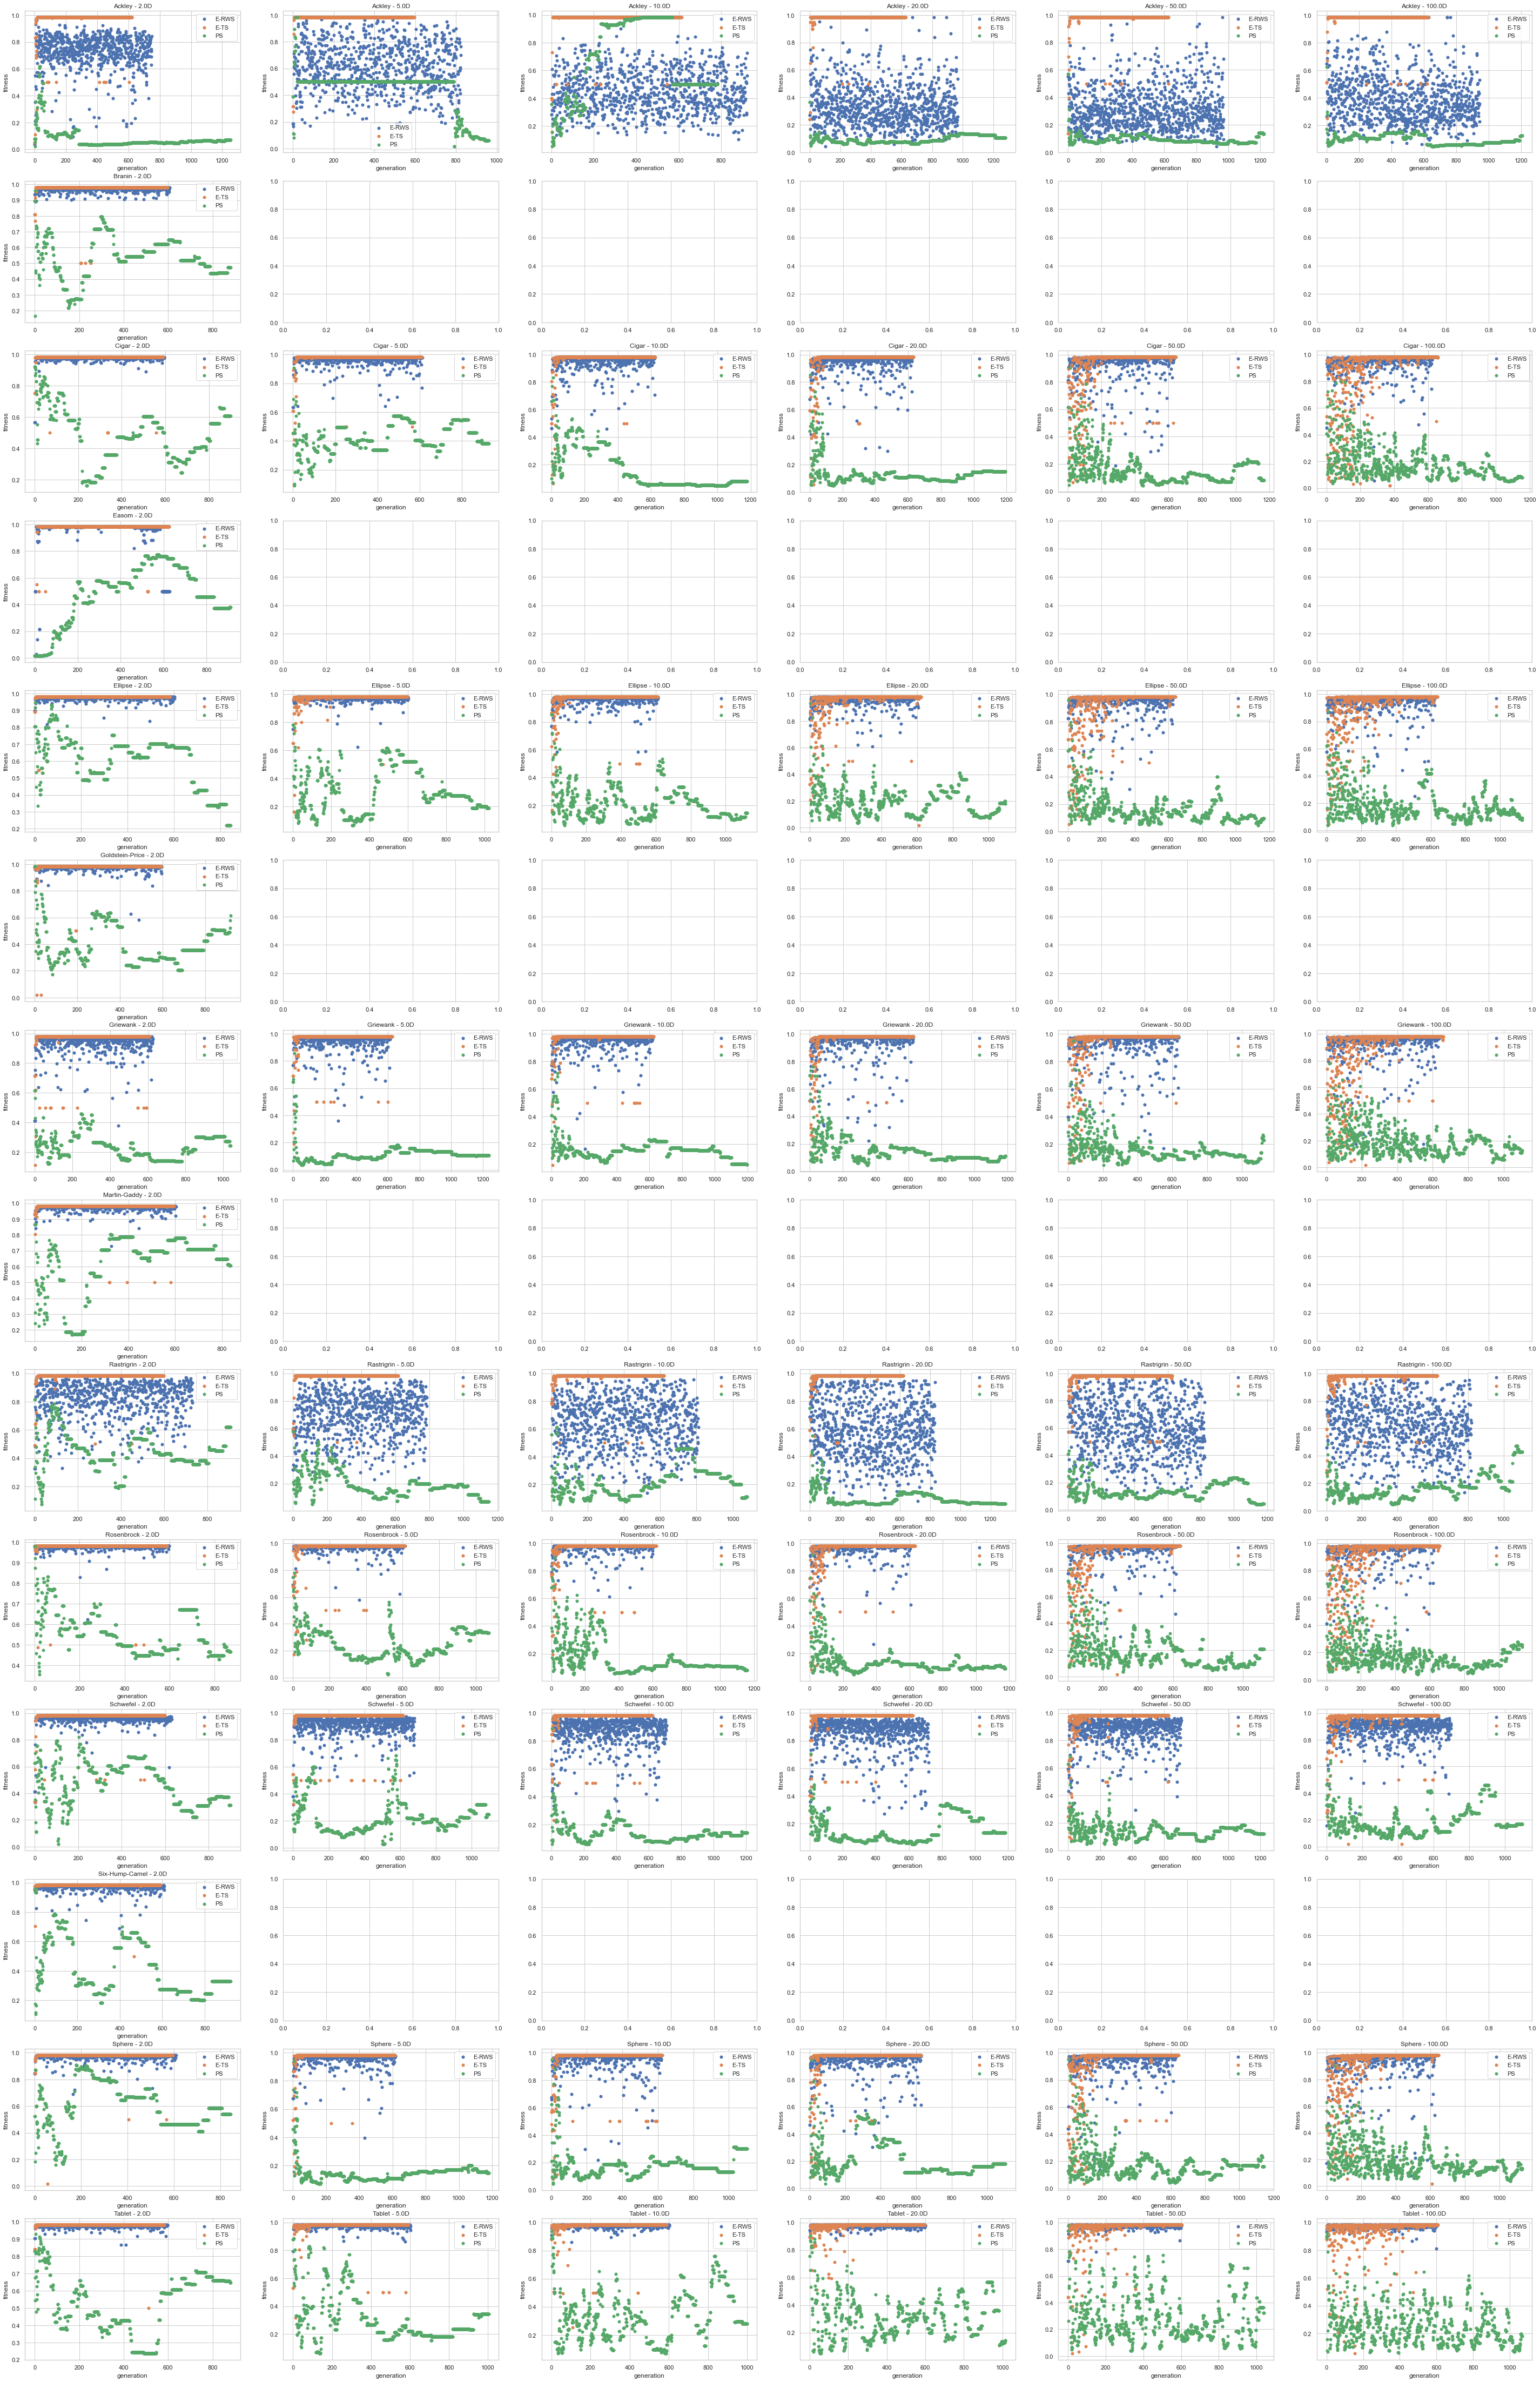

In [77]:
fig, axs = plt.subplots(nrows=14,ncols=6, figsize=(50,80))
row = 0
for benchmark in fitness_df.benchmark.unique():
    benchmark_fdf = fitness_df[fitness_df['benchmark'] == benchmark]
    column=0
    for dim in benchmark_fdf.dimensions.unique():
        data = benchmark_fdf[benchmark_fdf['dimensions'] == dim]
        for selection_method in data.selection_method.unique():
            plot_data = data[data['selection_method'] == selection_method].groupby('generation').median()
            sns.scatterplot(x='generation', y='fitness',data=plot_data, label=renames[selection_method], linewidth=0, ax = axs[row][column]).set_title(f'{benchmark} - {dim}D') #alpha=1-(i/10),
        column+=1
    row+=1
plt.savefig(f'PPA/notebooks/brouwer_vandenberg_2022/test-all-benchmark-median-fitness-erws-ets-cs.png', bbox_inches='tight')
plt.show()
